In [265]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import scipy.stats as stats

In [18]:
parser = 'html.parser' # or 'lxml'
filter_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter'
table_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html'

#define the parameter
payload = {'ww_i_reportModel':'133685247'}

#define the table name
table_name = {
    'unite_faculty':'ww_x_UNITE_ACAD',
    'academic_year':'ww_x_PERIODE_ACAD', 
    'semester':'ww_x_PERIODE_PEDAGO',
    'season':'ww_x_HIVERETE'
}

# request example
default_parameter_dict = {
    'ww_b_list':1,
    'ww_i_reportmodel':'133685247',
    'ww_i_reportModelXsl':'133685270'
}


table_columns = [
    'Civilité',
    'Nom Prénom',
    'Orientation Bachelor',
    'Orientation Master',
    'Spécialisation',
    'Filière opt.',
    'Mineur',
    'Statut',
    'Type Echange',
    'Ecole Echange',
    'No Sciper'
]

table_columns_dict = dict(
    zip(table_columns, range(len(table_columns)))
)           

Find the URL

In [30]:
def get_url(input_url, parameters):
    return requests.get(input_url, params=parameters, timeout=30)

In [31]:
def build_key_map():
    # get the URL
#     r = requests.get(filter_url, params = payload)
    r = get_url(filter_url, payload)
    # convert to beautifulSoup
    soup = BeautifulSoup(r.text, parser)
    
    # extract the dictionary for Unité académique
    dict_unite = {}
    for table_key in table_name.keys():
        dict_unite_tem = {}
        for unite in soup.select('select[name=%s] option' % table_name[table_key]):
            if len(unite.contents) > 0:            
                dict_unite_tem[(unite.contents)[0]] = unite['value'] 
        dict_unite[table_key] = dict_unite_tem
    return dict_unite

dict_unite = build_key_map()

In [20]:
# function to complete the parameter dictionary
def func_parameter_dict(academic_year_str,season_str,semester_str,unite_faculty_str,dict_unite, gps = False):
    # request example
    parameter_dict = default_parameter_dict
    parameter_dict[table_name['academic_year']] = dict_unite['academic_year'][academic_year_str]
    parameter_dict[table_name['season']] = dict_unite['season'][season_str]
    parameter_dict[table_name['semester']] = dict_unite['semester'][semester_str]
    parameter_dict[table_name['unite_faculty']] = dict_unite['unite_faculty'][unite_faculty_str]
    if gps:
        parameter_dict['ww_x_GPS'] = -1
    return parameter_dict

In [37]:
def get_required_webpage(academic_year_str,season_str,semester_str,unite_faculty_str,dict_unite):
    parameter_dict = func_parameter_dict(academic_year_str,season_str,semester_str,unite_faculty_str,dict_unite)
    # get the URL
#     r = requests.get(filter_url, params = parameter_dict)
    r = get_url(filter_url, parameter_dict)
    # convert to beautifulSoup
    soup = BeautifulSoup(r.text, parser)
    # check if the ww_x_GPS is exist or not, if it existed, ww_x_GPS == -1
    if soup.select('a[class=%s]' % "ww_x_GPS")==[]:
        print('The input is not valide')
        print(semester_str)
        raise RuntimeError
        
    # update parameter, add ww_x_GPS
    gps_exist = True
    parameter_dict_gps =  func_parameter_dict(academic_year_str,season_str,semester_str,
                                          unite_faculty_str,dict_unite, gps_exist)

    # get the URL
    r_table = get_url(table_url, parameter_dict_gps)
    # convert to beautifulSoup
    soup_table = BeautifulSoup(r_table.text, parser)
    return soup_table

In [38]:
import pandas as pd

def build_dataframe(soup, list_of_columns):
    l = soup.select('table tr')
    # The first row is the title of the table
    # The second row is the label of columns
    s = []
    
    for column in list_of_columns:
        temp_s = []
        for item in l[2:]:
            content = item.contents[table_columns_dict[column]].contents
            if (content == []):
                temp_s.append('None')
            else:
                temp_s.append(content[0])
        s.append(temp_s)
                
    column_dict = dict(zip(list_of_columns, s))
    df = pd.DataFrame(column_dict)
    return df

# Example

In [39]:
academic_year_str = '2007-2008'
season_str = "Semestre d'automne"
semester_str = 'Bachelor semestre 1'
unite_faculty_str =  'Informatique'

In [40]:
# Get the Raw Webpage
soup_table = get_required_webpage(academic_year_str,season_str,semester_str,unite_faculty_str,dict_unite)

In [41]:
# Create a DataFrame from the raw webpage
df = build_dataframe(soup_table, ['No Sciper', 'Statut'])
df.head()

,No Sciper,Statut
0,169569,Présent
1,174905,Présent
2,173922,Présent
3,179406,Présent
4,179428,Présent


# Assignment 1

In [42]:
def func_get_semester_student(season_str, semester_str, unite_faculty_str, feature_list):
    """Request data for the given condition and return a dataframe. Only semester after 2007 is considered."""
    # Request for year 2007 to 2017 and build dataframes. 
    df_list = []
    for year in range(2007, 2016):
        academic_year_str = str(year) + '-' + str(year+1)
        soup_table = get_required_webpage(academic_year_str,season_str,semester_str,unite_faculty_str,dict_unite)    
        df =build_dataframe(soup_table, feature_list)
        # Plugin a column of academic_year
        df['academic_year']=academic_year_str
        df_list.append(df)
    
    # Concatenate dataframe and insert a column of semester.
    df = pd.concat(df_list)
    df['Semester'] = semester_str
    df1 = df.set_index(['No Sciper','academic_year'])
    df2 = df.set_index(['No Sciper'])
    unique_index = df2.index.unique()
    return df1, unique_index

In [43]:
season_str = ["Semestre d'automne","Semestre de printemps"]
semester_str = ['Bachelor semestre 1','Bachelor semestre 6']
feature_list = ['Nom Prénom', 'No Sciper', 'Statut', 'Civilité']
unite_faculty_str =  'Informatique'
df_semester_1,unique_index_1 = func_get_semester_student(season_str[0],semester_str[0],unite_faculty_str, feature_list)
df_semester_6,unique_index_6 = func_get_semester_student(season_str[1],semester_str[1],unite_faculty_str, feature_list)

In [110]:
df_semester_1.head()

,,Civilité,Nom Prénom,Statut,Semester
No Sciper,academic_year,,,,
169569,2007-2008,Monsieur,Arévalo Christian,Présent,Bachelor semestre 1
174905,2007-2008,Monsieur,Aubelle Flavien,Présent,Bachelor semestre 1
173922,2007-2008,Monsieur,Badoud Morgan,Présent,Bachelor semestre 1
179406,2007-2008,Monsieur,Baeriswyl Jonathan,Présent,Bachelor semestre 1
179428,2007-2008,Monsieur,Barroco Michael,Présent,Bachelor semestre 1


As there are some students have two or more bachelor semeseter 1s and bachelor semeseter 6s, we would like to find the *earliest* bacholor semester 1 and *last* bacholor semester 6 in EPFL.

In [55]:
def find_beg_end_year(df_semester, unique_idx, find_end):
    """Return a dataframe with first year or last year in EPFL"""
    unique_index = unique_idx
    
    # Sort dataframe so that the academic years are in the order `2007-2008`, `2008-2009`, ...
    sorted_dataframe = df_semester.sort_index()
    
    list_year = []
    list_Sciper = unique_idx
    list_sex = []

    # If we want to `find_end`, then `required_year_idx == -1` refers to the last element
    # of sorted year, that is, the last year in a given semester
    required_year_idx = -1 if find_end else 0
    for i in unique_index:
        academic_year = sorted_dataframe.loc[i,:].iloc[required_year_idx].name
        list_year.append(academic_year)
        list_sex.append(sorted_dataframe['Civilité'].loc[(i,academic_year)])
    
    dic = {'No Sciper':list_Sciper, 'academic_year':list_year, 'Civilité':list_sex}    
    dataframe_dic = pd.DataFrame(dic)
    
    return dataframe_dic.set_index('No Sciper')

In [117]:
def find_beg_end_year1(df_semester, unique_sciper_idx, find_end):
    """Return a new dataframe with either first year or last year in EPFL"""    
    if find_end:
        grouped = df_semester.reset_index().groupby(['No Sciper']).max()
    else:
        grouped = df_semester.reset_index().groupby(['No Sciper']).min()
    
    required_index = grouped.reset_index().set_index(['No Sciper', 'academic_year']).index
    
    return df_semester.loc[required_index].reset_index().set_index(['No Sciper'])

In assignment 1, we calculate the bachelor 1 and bachelor 6

In [192]:
semester1_frame = find_beg_end_year1(df_semester_1,unique_index_1, find_end=False)
semester6_frame = find_beg_end_year1(df_semester_6,unique_index_6, find_end=True)

In [193]:
semester1_frame.head()

,academic_year,Civilité,Nom Prénom,Statut,Semester
No Sciper,,,,,
147008,2008-2009,Monsieur,Good Xavier,Présent,Bachelor semestre 1
161212,2009-2010,Monsieur,Tamesna Rachid,Présent,Bachelor semestre 1
169569,2007-2008,Monsieur,Arévalo Christian,Présent,Bachelor semestre 1
169731,2007-2008,Monsieur,Knecht Mathieu,Présent,Bachelor semestre 1
169795,2007-2008,Monsieur,Scheiben Pascal,Présent,Bachelor semestre 1


In [194]:
# Select students who appears in both bachelor semeseter 1 and 6
id = semester1_frame[semester1_frame.Statut == 'Présent'].index\
        .intersection(semester6_frame[semester6_frame.Statut == 'Présent'].index)

# Concatenate two dataframes and compute the parse the academic year to 
result = pd.concat([semester1_frame[['academic_year']].loc[id], 
                    semester6_frame[['academic_year', 'Civilité']].loc[id]],axis = 1)

result.columns = ['start', 'end', 'Civilité']

# Parse string and calculate the duration in month
year_in_months = 12
result['duration(month)'] = result.apply(lambda x: year_in_months * 
                                         (int(x.iloc[1].split('-')[1])-int(x.iloc[0].split('-')[0])), axis=1)

result.head()

,start,end,Civilité,duration(month)
No Sciper,,,,
169569,2007-2008,2009-2010,Monsieur,36
169731,2007-2008,2010-2011,Monsieur,48
169795,2007-2008,2010-2011,Monsieur,48
171195,2007-2008,2009-2010,Monsieur,36
171619,2007-2008,2009-2010,Monsieur,36


In [197]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [199]:
result.groupby(['start']).agg([np.mean, np.std])

duration(month)           
                     mean        std
start                               
2007-2008       42.857143   8.901578
2008-2009       43.411765  10.239903
2009-2010       48.000000  12.828540
2010-2011       42.418605   8.006642
2011-2012       44.769231   9.831154
2012-2013       42.000000   6.052403
2013-2014       36.000000   0.000000

### Average time spend for 6 semesters
Every year, student on average spend around `42` month on the 6 semesters. During `2009-2010`, people spend longer time (around 48 month). During `2013-2014`, on the other hand, all students graduated with 36 months.

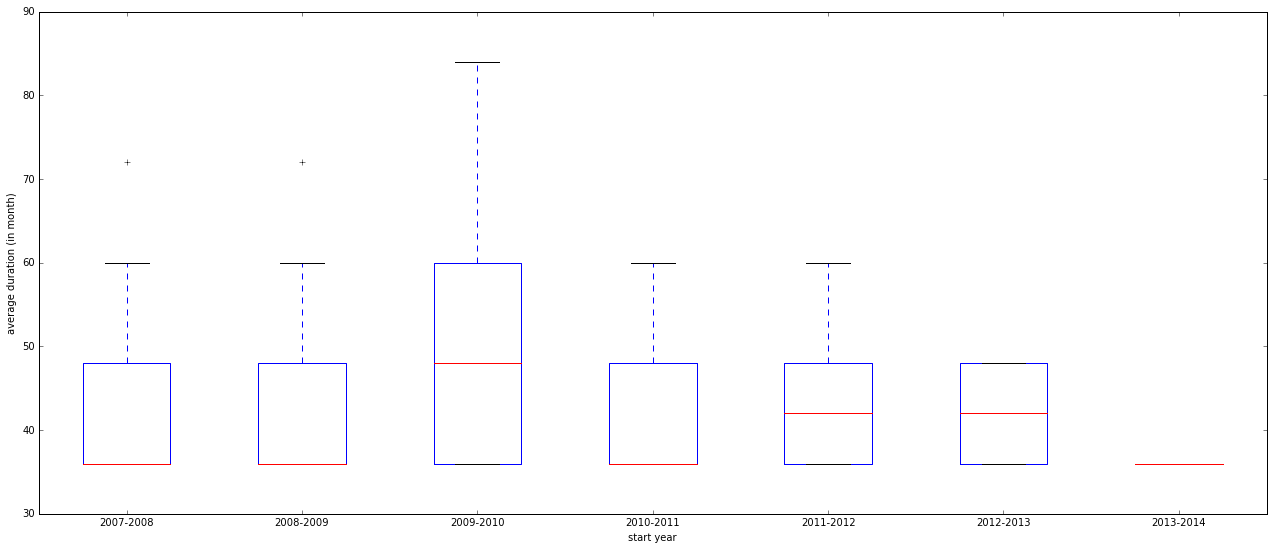

In [201]:
l = []
star_year = []
for key, grp in result.groupby(['start']):
    l.append(grp['duration(month)'])
    star_year.append(key)

plt.boxplot(l,labels=star_year,)
plt.xlabel('start year')
plt.ylabel('average duration (in month)')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 22
fig_size[1] = 9
plt.show()

### Discuss the relation between average stay time and sex
Observe the following plot. Before `2011-2012`, females usually spend less times than males to graudate. After that, the difference become smaller. We first guess that female and male student have same expected graduate time and the deviation is due to the small number of females.

In [260]:
gender_bachelor = result.reset_index().groupby(['start', 'Civilité'])['duration(month)'].value_counts()
gender_bachelor

start      Civilité  duration(month)
2007-2008  Monsieur  36                 15
                     48                 11
                     60                  1
                     72                  1
2008-2009  Madame    36                  3
                     48                  1
           Monsieur  36                 17
                     48                  7
                     60                  5
                     72                  1
2009-2010  Madame    36                  1
                     48                  1
           Monsieur  36                 14
                     48                  9
                     60                  8
                     72                  2
                     84                  1
2010-2011  Madame    36                  2
           Monsieur  36                 22
                     48                 15
                     60                  4
2011-2012  Madame    36                  4
                 

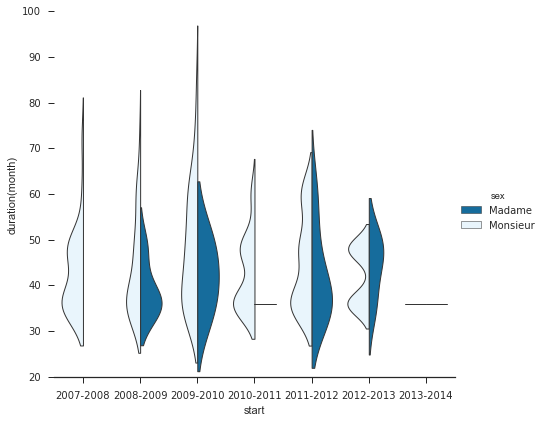

In [257]:
# plt.rcParams['figure.figsize']=(10,10)
g = sns.FacetGrid(result.reset_index(), size=6, aspect=1.1)
g = g.map(sns.violinplot, "start", "duration(month)","Civilité",
          inner=None, linewidth=1, scale="area", split=True, width=0.75, size=12)\
        .despine(left=True).add_legend(title="sex")

#### Statistic Test
The **null hypothesis** is: females and males spend same amount of time to get a bachelor's degree on average.

It is reasonable to assume that admission standard of EPFL did not change a lot in between 2007 to now. So the expected time spend on 6 semester should remain unchanged for both male and female. As a result, we focus on the relation between `sex` and `duration`, and didn't take `academic_year` into consideration. In this way, we can also avoid pitfall of the lack of female students.

We use two sample T-test to reject/accept this hypothesis. 
We set **confidence level** to be 95%, that is, the pvalue is 5%.

In [280]:
group_bachelor_sex = result.reset_index()[['Civilité', 'duration(month)']].groupby('Civilité')
male_time = group_bachelor_sex.get_group('Monsieur')['duration(month)']
female_time = group_bachelor_sex.get_group('Madame')['duration(month)']
stats.ttest_ind(a= minnesota_ages,
                b= wisconsin_ages)

Ttest_indResult(statistic=-1.7083870793286842, pvalue=0.090730153865142563)

As the pvalue is approximately 9% which is larger than 5%, we believe the above case is not extreme event. Thus the null hypothesis hold under such confidence level. 

We believe, female students and male students have same expected duration between semester 1 and semester 6.

## Assignment 2

In [312]:
# extract the semester 1 and semester 2 student list
season_str = ["Semestre d'automne","Semestre de printemps"]
semester_str = ['Master semestre 1','Master semestre 2','Master semestre 3','Projet Master automne','Projet Master printemps']
feature_list = ['Nom Prénom', 'No Sciper', 'Statut', 'Civilité','Spécialisation','Mineur']
unite_faculty_str =  'Informatique'
df_master_semester_1,unique_master_index_1 = func_get_semester_student(season_str[0],semester_str[0],unite_faculty_str, feature_list)
df_master_semester_2,unique_master_index_2 = func_get_semester_student(season_str[1],semester_str[1],unite_faculty_str, feature_list)
df_master_semester_3,unique_master_index_3 = func_get_semester_student(season_str[0],semester_str[2],unite_faculty_str, feature_list)
df_master_project_1,unique_master_project_index_1 = func_get_semester_student(season_str[0],semester_str[3],unite_faculty_str, feature_list)
df_master_project_2,unique_master_project_index_2 = func_get_semester_student(season_str[1],semester_str[4],unite_faculty_str, feature_list)

In [319]:
df_master_project_2.head()

,,Civilité,Mineur,Nom Prénom,Spécialisation,Statut,Semester
No Sciper,academic_year,,,,,,
159852,2007-2008,Monsieur,None,Brutsche Florian,Internet computing,Congé,Projet Master printemps
153819,2007-2008,Monsieur,None,Dotta Mirco,None,Stage,Projet Master printemps
145957,2007-2008,Monsieur,None,Hügli Michael,None,Stage,Projet Master printemps
173257,2007-2008,Monsieur,None,Indra Saurabh,None,Présent,Projet Master printemps
160150,2007-2008,Monsieur,None,Lépine Simon,Biocomputing,Présent,Projet Master printemps


In [338]:
master_all_semesters = pd.concat([df_master_semester_1, df_master_semester_2,\
                                  df_master_semester_3, df_master_project_1, df_master_project_2]).reset_index()

In [344]:
present_in_epfl = master_all_semesters.groupby(['No Sciper', 'Statut']).count()['Civilité']

In [351]:
count_stay = present_in_epfl.loc[:, 'Présent']
average_stay = count_stay.mean()

In [365]:
specialization_count = master_all_semesters[(master_all_semesters.Statut == 'Présent') 
                     & (master_all_semesters.Spécialisation != 'None')].groupby(['Spécialisation','No Sciper']).count()['Civilité']

In [403]:
specialization_count

Spécialisation                  No Sciper
Biocomputing                    153640       1
                                154573       4
                                154936       1
                                154969       1
                                160150       2
                                160831       1
                                161090       1
                                169734       3
                                172500       1
                                172503       1
                                172611       1
                                183185       1
Computer Engineering - SP       161344       1
                                166262       1
                                175775       1
                                178271       3
                                178283       2
                                183984       2
                                185005       2
                                185458       3
                  

In [369]:
specialization_count.reset_index().groupby(['Spécialisation']).mean()

,Civilité
Spécialisation,
Biocomputing,1.500000
Computer Engineering - SP,2.227273
Computer Science Theory,2.000000
Data Analytics,1.750000
Foundations of Software,2.289855
Information Security - SP,2.428571
Internet Information Systems,2.000000
Internet computing,2.240741
Service science,2.000000


In [371]:
master_all_semesters[(master_all_semesters.Spécialisation == 'Biocomputing') ]

,No Sciper,academic_year,Civilité,Mineur,Nom Prénom,Spécialisation,Statut,Semester
42,172611,2007-2008,Monsieur,None,Kwanga Rodrigue,Biocomputing,Présent,Master semestre 1
971,172500,2007-2008,Madame,None,Diatchka Kremena Sotirova,Biocomputing,Présent,Master semestre 2
1039,154573,2008-2009,Madame,None,Benabdallah Zeineb,Biocomputing,Présent,Master semestre 2
1068,169734,2008-2009,Monsieur,None,Koller Yannick,Biocomputing,Présent,Master semestre 2
2022,172500,2007-2008,Madame,None,Diatchka Kremena Sotirova,Biocomputing,Stage,Master semestre 3
2024,160831,2007-2008,Monsieur,None,Dubout Charles,Biocomputing,Présent,Master semestre 3
2026,172503,2007-2008,Monsieur,None,Evans Nathaniel,Biocomputing,Présent,Master semestre 3
2033,161090,2007-2008,Monsieur,None,Habersaat Alexandre,Biocomputing,Présent,Master semestre 3
2046,160150,2007-2008,Monsieur,None,Lépine Simon,Biocomputing,Présent,Master semestre 3
2048,153640,2007-2008,Monsieur,None,Matthey-de-l'Endroit Loïc,Biocomputing,Présent,Master semestre 3


In [378]:
people_with_spec_idx = master_all_semesters[(master_all_semesters.Statut == 'Présent') 
                     & (master_all_semesters.Spécialisation != 'None')]['No Sciper'].unique()

In [406]:
specialization_count = master_all_semesters.set_index('No Sciper').loc[people_with_spec_idx].reset_index().groupby(['Spécialisation','No Sciper']).count()['Civilité']

In [407]:
specialization_count.reset_index().groupby(['Spécialisation']).mean()

,Civilité
Spécialisation,
Biocomputing,1.583333
Computer Engineering - SP,2.409091
Computer Science Theory,2.000000
Data Analytics,1.750000
Foundations of Software,2.782609
Information Security - SP,2.428571
Internet Information Systems,2.000000
Internet computing,2.555556
None,1.381443


# Bonus